# MTH-IDS Adoption Using UNSW-NB15
This is an adoption of the method described in the paper entitled "[**MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles**](https://arxiv.org/pdf/2105.13289.pdf)" accepted in IEEE Internet of Things Journal using UNSW-NB15 dataset to test its performance.  

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the UNSW-NB15 dataset
The UNSW-NB15 dataset is publicly available at: https://research.unsw.edu.au/projects/unsw-nb15-dataset  
This notebook uses a merged version of the dataset, please firstly run Prepare_UNSW-NB15_Dataset.ipynb to automatically download the dataset and do the merge  
*Note: This project downloads the dataset from Kaggle, which is found to be just a copy of the original dataset*

In [3]:
#Read dataset
df = pd.read_csv('data/UNSW-NB15.csv')

In [4]:
df

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390.0,149.171.126.6,53.0,udp,CON,0.001055,132,164,31,...,0.0,3,7,1,3,1,1,1,Normal,0
1,59.166.0.0,33661.0,149.171.126.9,1024.0,udp,CON,0.036133,528,304,31,...,0.0,2,4,2,3,1,1,2,Normal,0
2,59.166.0.6,1464.0,149.171.126.7,53.0,udp,CON,0.001119,146,178,31,...,0.0,12,8,1,2,2,1,1,Normal,0
3,59.166.0.5,3593.0,149.171.126.5,53.0,udp,CON,0.001209,132,164,31,...,0.0,6,9,1,1,1,1,1,Normal,0
4,59.166.0.3,49664.0,149.171.126.0,53.0,udp,CON,0.001169,146,178,31,...,0.0,7,9,1,1,1,1,1,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539734,59.166.0.5,33094.0,149.171.126.7,43433.0,tcp,FIN,0.087306,320,1828,31,...,-1.0,1,2,3,3,1,1,3,Normal,0
2539735,59.166.0.7,20848.0,149.171.126.4,21.0,tcp,CON,0.365058,456,346,31,...,2.0,2,2,2,2,2,2,2,Normal,0
2539736,59.166.0.3,21511.0,149.171.126.9,21.0,tcp,CON,6.335154,1802,2088,31,...,2.0,2,2,4,2,2,2,2,Normal,0
2539737,59.166.0.9,35433.0,149.171.126.0,80.0,tcp,CON,2.200934,3498,166054,31,...,-1.0,1,1,2,4,2,2,2,Normal,0


In [5]:
df['attack_cat'].value_counts()

Normal            2218456
Generic            215481
Exploits            44525
Fuzzers             24246
DoS                 16353
Reconnaissance      13987
Analysis             2677
Backdoor             2329
Shellcode            1511
Worms                 174
Name: attack_cat, dtype: int64

### Early Feature Selection (remove useless features in the dataset)
Refering to the training set included in the files downloaded from Kaggle

In [6]:
# # Read the downloaded training set
# df_training = pd.read_csv('data/achieve/UNSW_NB15_training-set.csv', index_col='id')
# # Get feature set
# features = df_training.columns.to_list()
# # Adjustments
# # Rename some feature names to match the complete dataset
# rename_dict = {
#     'smean': 'smeansz',
#     'dmean': 'dmeansz',
#     'response_body_len': 'res_bdy_len',
#     'sinpkt': 'sintpkt',
#     'dinpkt': 'dintpkt'
# }
# features = list(map(lambda x: rename_dict[x] if x in rename_dict else x, features))
# # Remove feature 'rate' since it is not in the dataset
# features.remove('rate')
# # Remove feature 'label' to match the original code of MTH-IDS_IoTJ
# features.remove('label')
# # Release Memory
# del df_training

# For convenience
features = ['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
 'sintpkt', 'dintpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smeansz', 'dmeansz', 'trans_depth',
 'res_bdy_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login',
 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat']

print(features)

['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sintpkt', 'dintpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat']


In [7]:
# Only keep the influencing features
df = df[features]

### Preprocessing (normalization and padding values)

In [8]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [9]:
temp_labels = df['attack_cat'].value_counts().index.to_list()

In [10]:
labelencoder = LabelEncoder()
for col_name in df.dtypes[df.dtypes == 'object'].index:
      df[col_name] = labelencoder.fit_transform(df[col_name])

In [11]:
df['attack_cat'].value_counts()

6    2218456
5     215481
3      44525
4      24246
2      16353
7      13987
0       2677
1       2329
8       1511
9        174
Name: attack_cat, dtype: int64

In [12]:
label_names = []
temp_series = df['attack_cat'].value_counts().index.to_list()
for i in range(len(temp_labels)):
    label_names.append(temp_labels[temp_series.index(i)])
del temp_labels
del temp_series
label_names

['Analysis',
 'Backdoor',
 'DoS',
 'Exploits',
 'Fuzzers',
 'Generic',
 'Normal',
 'Reconnaissance',
 'Shellcode',
 'Worms']

In [13]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['attack_cat']==0)|(df['attack_cat']==1)|(df['attack_cat']==9)|(df['attack_cat']==2)|(df['attack_cat']==10)]
df_major = df.drop(df_minor.index)

In [14]:
X = df_major.drop(['attack_cat'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [15]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [16]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [17]:
df_major['klabel'].value_counts()

406    13180
47      9189
555     9022
708     8407
453     8246
       ...  
86        93
359       92
303       74
966       74
405       54
Name: klabel, Length: 1000, dtype: int64

In [18]:
cols = list(df_major)
cols.insert(41, cols.pop(cols.index('attack_cat')))
df_major = df_major.loc[:, cols]

In [19]:
df_major

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,sttl,dttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,klabel
0,-0.047237,119,2,2,-0.410191,-0.335218,-0.074599,-0.225120,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.475500,-0.183860,-0.040675,6,240
1,-0.044718,119,0,2,-0.383975,-0.318758,-0.067579,-0.224251,-0.425873,-0.041315,...,-0.419941,-0.430468,1.024811,0.984974,0.511771,-0.475500,-0.461052,-0.040675,6,416
2,-0.047232,119,2,2,-0.410191,-0.335218,-0.074351,-0.225033,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.597372,-0.091463,-0.040675,6,520
3,-0.047226,119,2,2,-0.410191,-0.335218,-0.074599,-0.225120,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.719244,0.000935,-0.040675,6,240
4,-0.047229,119,2,2,-0.410191,-0.335218,-0.074351,-0.225033,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.719244,0.000935,-0.040675,6,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539734,-0.041043,113,4,5,-0.357758,-0.285839,-0.071266,-0.214791,-0.425873,-0.041315,...,-0.419941,-0.341649,-0.853666,-0.831158,-0.704894,-0.475500,-0.645847,-0.040675,6,626
2539735,-0.021098,113,3,2,-0.331542,-0.302299,-0.068855,-0.223990,-0.425873,-0.041315,...,-0.257991,-0.430468,4.781765,4.617237,-0.704894,-0.597372,-0.645847,-0.040675,6,196
2539736,0.407611,113,3,2,-0.016943,-0.104781,-0.044994,-0.213177,-0.425873,-0.041315,...,-0.257991,-0.430468,4.781765,4.617237,-0.704894,-0.597372,-0.645847,-0.040675,6,31
2539737,0.110735,113,5,2,0.323872,0.602988,-0.014928,0.804579,-0.425873,-0.041315,...,-0.257991,-0.430468,-0.853666,-0.831158,2.945100,-0.353628,-0.738245,-0.040675,6,225


In [20]:
def typicalSampling(group):
    name = group.name
    frac = 0.024
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [21]:
result['attack_cat'].value_counts()

6    53233
5     5178
3     1065
4      584
7      352
8       35
Name: attack_cat, dtype: int64

In [22]:
result

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,sttl,dttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,klabel
782914,-0.047235,119,2,2,-0.410191,-0.335218,-0.074351,-0.225033,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.597372,-0.738245,-0.040675,6,0
526760,-0.047237,119,2,2,-0.410191,-0.335218,-0.074351,-0.225033,-0.425873,-0.041315,...,-0.419941,-0.430468,1.024811,0.984974,0.511771,-0.475500,-0.738245,-0.040675,6,0
57391,-0.047244,119,2,2,-0.410191,-0.335218,-0.074634,-0.225132,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.597372,-0.645847,-0.040675,6,0
78075,-0.047243,119,2,2,-0.410191,-0.335218,-0.074351,-0.225033,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.597372,-0.645847,-0.040675,6,0
388081,-0.047235,119,2,2,-0.410191,-0.335218,-0.074351,-0.225033,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.597372,-0.645847,-0.040675,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397994,-0.047235,119,2,2,-0.410191,-0.335218,-0.074351,-0.225033,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.719244,-0.645847,-0.040675,6,999
719605,-0.047235,119,2,2,-0.410191,-0.335218,-0.074351,-0.225033,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.719244,-0.645847,-0.040675,6,999
50852,-0.047235,119,2,2,-0.410191,-0.335218,-0.074351,-0.225033,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.719244,-0.645847,-0.040675,6,999
899074,-0.047235,119,2,2,-0.410191,-0.335218,-0.074351,-0.225033,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.719244,-0.645847,-0.040675,6,999


In [23]:
result = result.drop(['klabel'],axis=1)
result = result.append(df_minor)

In [24]:
result.to_csv('./data/UNSW-NB15_sample_km.csv',index=0)

### split train set and test set

In [25]:
df=pd.read_csv('./data/UNSW-NB15_sample_km.csv')

In [26]:
X = df.drop(['attack_cat'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

In [28]:
# Prepare the result output
output_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Train_time', 'Predict_time_per_record', 'HPO_time'])
output_index = list()

### Feature selection by information gain

In [29]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [30]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [31]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [32]:
X_fs = df[fs].values

In [33]:
X_fs.shape

(81980, 28)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [34]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [35]:
t1 = time.time()
X_fss = fcbf.fit_transform(X_fs,y)
t2 = time.time()

In [36]:
# Add to output sheet
result_dict = {
    'Accuracy': np.NaN,
    'Precision': np.NaN,
    'Recall': np.NaN,
    'F1-Score': np.NaN,
    'Train_time': t2-t1,
    'Predict_time_per_record': np.NaN,
    'HPO_time': np.NaN
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('FCBF')

In [37]:
X_fss.shape

(81980, 20)

### Re-split train & test sets after feature selection

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [39]:
X_train.shape

(65584, 20)

In [40]:
pd.Series(y_train).value_counts()

6    42587
2    13082
5     4142
0     2142
1     1863
3      852
4      467
7      282
9      139
8       28
dtype: int64

### SMOTE to solve class-imbalance

In [41]:
sampling_strategy = dict()
smote_threshold = 1000
for key, value in df['attack_cat'].value_counts().to_dict().items():
    if value < smote_threshold: sampling_strategy[key]=smote_threshold

In [42]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy=sampling_strategy)

In [44]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [45]:
pd.Series(y_train).value_counts()

6    42587
2    13082
5     4142
0     2142
1     1863
4     1000
7     1000
9     1000
8     1000
3      852
dtype: int64

In [46]:
X_combined = np.concatenate((X_train, X_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

In [47]:
# The length of the test set for prediction time measurement
len_test = X_test.shape[0]
# Prepare the output dir
output_dir = 'output/MTH-IDS/output-{}'.format(datetime.datetime.now().strftime('%y%m%d-%H%M%S'))
img_dir = os.path.join(output_dir, 'img')
os.makedirs(img_dir)
# Prepare the log file
log_file = open(os.path.join(output_dir, 'classification_report-{}'.format(datetime.datetime.now().strftime('%y%m%d-%H%M%S'))), 'w+')

#### Apply XGBoost

[22:25:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.9194925591607709
Precision of XGBoost: 0.9279779283188772
Recall of XGBoost: 0.9194925591607709
F1-score of XGBoost: 0.9023944394676798
                precision    recall  f1-score   support

      Analysis       0.84      0.20      0.33       535
      Backdoor       0.81      0.09      0.17       466
           DoS       0.74      0.97      0.84      3271
      Exploits       0.85      0.10      0.18       213
       Fuzzers       0.42      0.50      0.46       117
       Generic       1.00      0.98      0.99      1036
        Normal       1.00      0.99      0.99     10646
Reconnaissance       0.85      0.74      0.79        70
     She

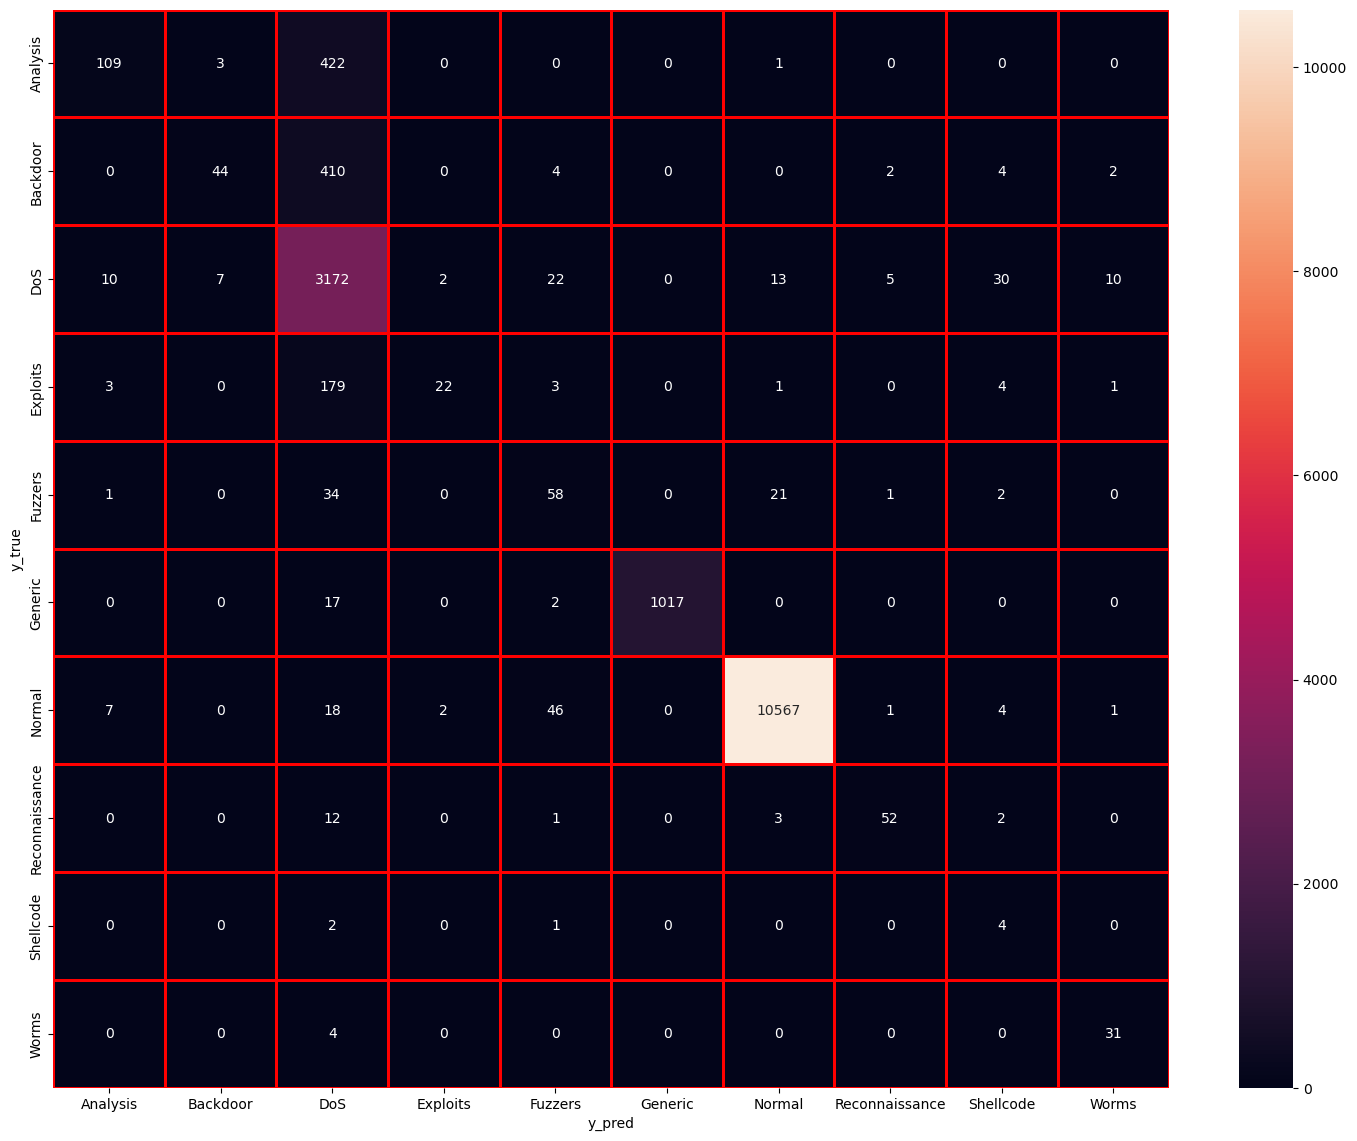

In [48]:
xg = xgb.XGBClassifier(n_estimators = 10)
t1 = time.time()
xg.fit(X_train,y_train)
t2 = time.time()
xg_score=xg.score(X_test,y_test)
t3 = time.time()
y_predict=xg.predict(X_test)
t4 = time.time()
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('XGBoost (Original)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=1,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'XGBoost_original.pdf'))
plt.show()

In [49]:
# Add to output sheet
result_dict = {
    'Accuracy': xg_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Train_time': t2-t1,
    'Predict_time_per_record': (t4-t3)/len_test,
    'HPO_time': np.NaN
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('XGBoost (Original)')

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [50]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

t1 = time.time()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

t2 = time.time()

print("XGBoost: Hyperopt estimated optimum {}".format(best))

[22:25:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:26:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:27:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:27:35] WARNI

[22:39:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.921566235667236
Precision of XGBoost: 0.9152286123031563
Recall of XGBoost: 0.921566235667236
F1-score of XGBoost: 0.9077657339995622
                precision    recall  f1-score   support

      Analysis       0.66      0.23      0.34       535
      Backdoor       0.52      0.14      0.22       466
           DoS       0.76      0.96      0.85      3271
      Exploits       0.73      0.22      0.34       213
       Fuzzers       0.45      0.46      0.46       117
       Generic       1.00      0.98      0.99      1036
        Normal       0.99      0.99      0.99     10646
Reconnaissance       0.83      0.76      0.79        70
     Shell

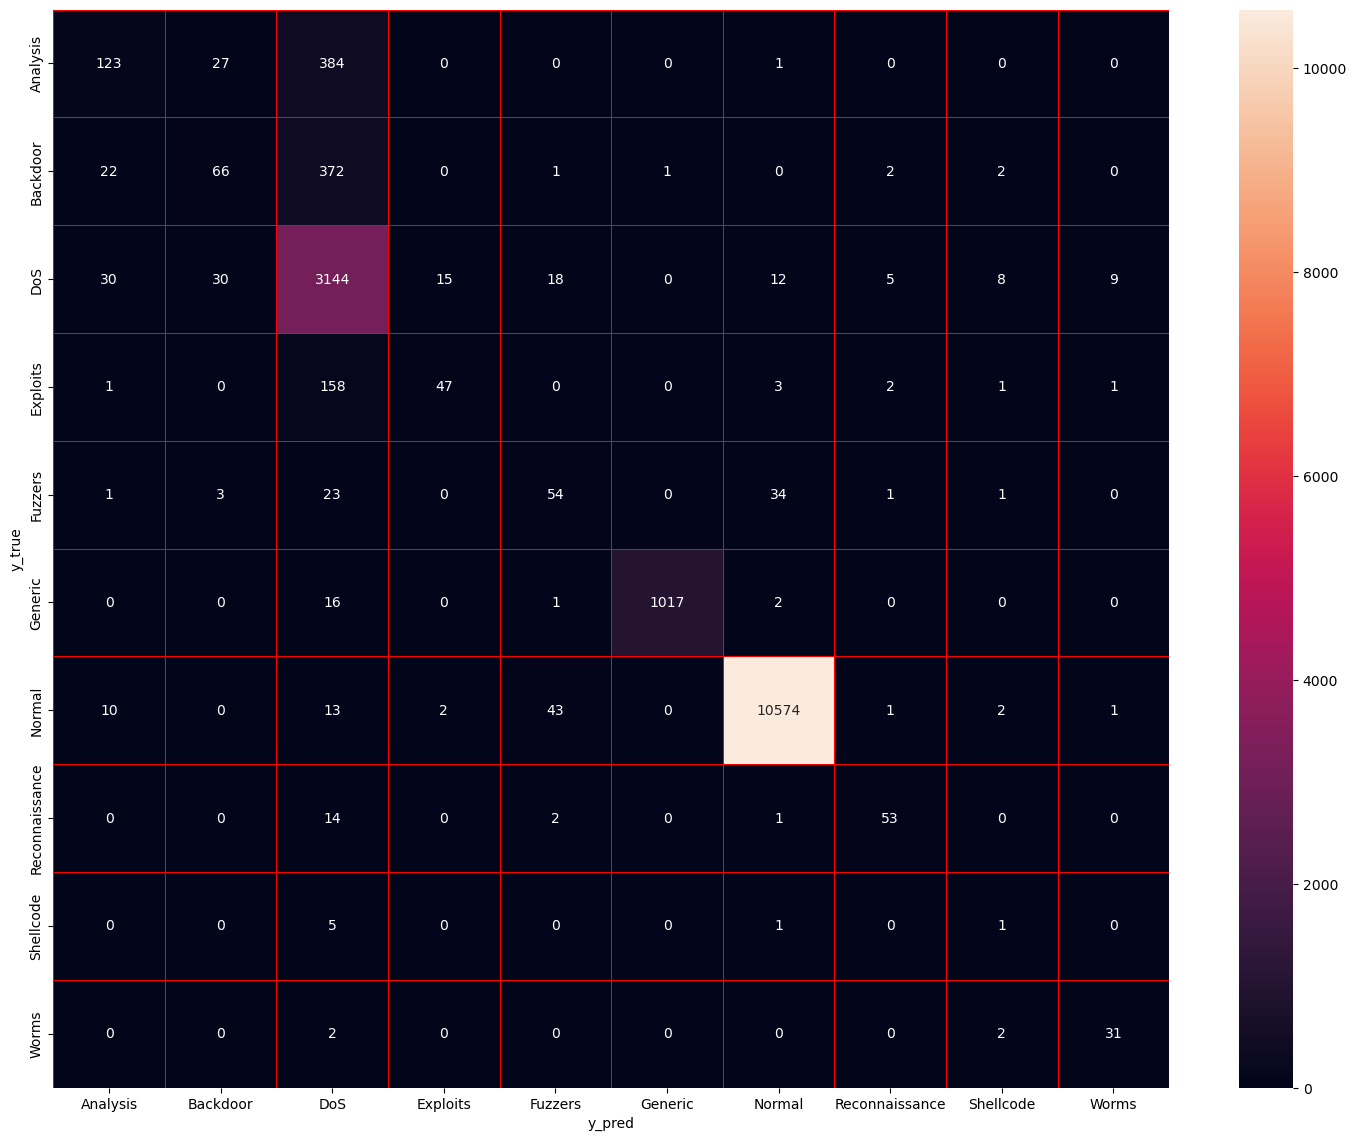

In [51]:
params = {
    'n_estimators': int(best['n_estimators']), 
    'max_depth': int(best['max_depth']),
    'learning_rate':  abs(float(best['learning_rate'])),
}
xg = xgb.XGBClassifier(**params)
t3 = time.time()
xg.fit(X_train,y_train)
t4 = time.time()
xg_score=xg.score(X_test,y_test)
t5 = time.time()
y_predict=xg.predict(X_test)
t6 = time.time()
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('XGBoost (BO-TPE)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'XGBoost_BO-TPE.pdf'))
plt.show()

In [52]:
# Add to output sheet
result_dict = {
    'Accuracy': xg_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('XGBoost (BO-TPE)')

In [53]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Hyperparameter optimization (HPO) of XGBoost using Particle Swarm Optimization (PSO)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [54]:
#XGBoost
import optunity
import optunity.metrics

data= X_combined
labels= y_combined.tolist()
Y_train = y_train
Y_test = y_test
# Define the hyperparameter configuration space
search = {
    'n_estimators': [10, 100],
    'max_depth': [5,50],
    'learning_rate': [0.01, 0.9]
}
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_estimators=None, max_depth=None,learning_rate=None):
    # fit the model
    params = {
        'n_estimators': int(n_estimators), 
        'max_depth': int(max_depth),
        'learning_rate':  abs(float(learning_rate)),
    }
    model = xgb.XGBClassifier( **params)
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    # scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
    #                                 scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return optunity.metrics.accuracy(Y_test, predictions)

t1 = time.time()

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )

t2 = time.time()

print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

[22:40:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[00:42:58] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.9419173210846051
Precision of XGBoost: 0.9437526349738788
Recall of XGBoost: 0.9419173210846051
F1-score of XGBoost: 0.9385153050657081
              precision    recall  f1-score   support

           0       0.52      0.76      0.62       535
           1       0.59      0.25      0.35       359
           2       0.52      0.96      0.68       107
           3       0.11      0.03      0.04        71
           4       0.78      0.45      0.57       218
           5       0.47      0.48      0.47       119
           6       1.00      0.98      0.99      1038
           7       1.00      0.99      0.99     10646
           8       0.73      0.82      0.77        68
          

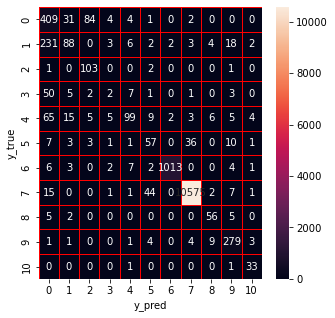

In [ ]:
params = {
    'n_estimators': int(optimal_configuration['n_estimators']), 
    'max_depth': int(optimal_configuration['max_depth']), 
    'learning_rate': abs(float(optimal_configuration['learning_rate']))
}
xg = xgb.XGBClassifier(**params)
t3 = time.time()
xg.fit(X_train,y_train)
t4 = time.time()
xg_score=xg.score(X_test,y_test)
t5 = time.time()
y_predict=xg.predict(X_test)
t6 = time.time()
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('XGBoost (PSO)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'XGBoost_PSO.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': xg_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('XGBoost (PSO)')

#### Hyperparameter optimization (HPO) of XGBoost using Genetic Algorithm (GA)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#Xgboost
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
    'n_estimators': range(10,100),
    'max_depth': range(4,100),
    'learning_rate': [i/100 for i in range(1, 90)]
}
# Set the hyperparameters of GA                 
ga = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'xgboost.XGBClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
t1 = time.time()
ga.fit(X_combined, y_combined)
t2 = time.time()

1 operators have been imported by TPOT.
[00:43:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:43:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:43:07] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:43:07] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting 

In [ ]:
# Helper method: convert the values represented by string to its correct type
def type_str(input_str:str):
    # is integer
    if input_str.isdecimal():
        return int(input_str)
    # is float
    elif input_str.isdigit():
        return float(input_str)
    # is string
    elif input_str.startswith('"') and input_str.endswith('"'):
        # remove quotation marks
        return input_str[1: -1]
    else:
        return input_str

# Extract the optimized parameter from the generated pipeline
def get_ga_optimized_parameters(fitted_tpot_obj: TPOTClassifier, classifier_name: str, temp_file_name:str='temp_ga_pipeline.py'):
    # Export the pipeline
    fitted_tpot_obj.export(output_file_name=temp_file_name)
    # Read the optimized pipeline
    with open(temp_file_name) as temp_file:
        lines = temp_file.readlines()
    for line in lines:
        if classifier_name+'(' in line.strip():
            pipeline = line
            break
    # Extract the optimized parameters
    start_index = pipeline.index(classifier_name+'(')
    end_index = pipeline.index(')')
    parameters_str = pipeline[start_index+len(classifier_name)+1: end_index]
    parameters = dict()
    for temp_str in parameters_str.split(sep=','):
        temp_list = temp_str.split('=')
        parameters[temp_list[0].strip()] = type_str(temp_list[1].strip())
    # Delect the temp file
    os.remove(temp_file_name)
    # Return the optimized parameters
    return parameters

In [ ]:
xg = xgb.XGBClassifier(**get_ga_optimized_parameters(ga, 'XGBClassifier'))
t3 = time.time()
xg.fit(X_train,y_train)
t4 = time.time()
xg_score=xg.score(X_test,y_test)
t5 = time.time()
y_predict=xg.predict(X_test)
t6 = time.time()
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('XGBoost (GA)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'XGBoost_GA.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': xg_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('XGBoost (GA)')

#### Apply RF

Accuracy of RF: 0.9339161357238109
Precision of RF: 0.9349308548885727
Recall of RF: 0.9339161357238109
F1-score of RF: 0.9333519631755297
              precision    recall  f1-score   support

           0       0.46      0.58      0.51       535
           1       0.34      0.25      0.28       359
           2       0.46      0.75      0.57       107
           3       0.10      0.07      0.08        73
           4       0.70      0.50      0.59       216
           5       0.52      0.54      0.53       124
           6       1.00      0.97      0.99      1032
           7       1.00      0.99      0.99     10649
           8       0.87      0.79      0.83        66
           9       0.89      0.96      0.92       302
          10       0.80      0.94      0.87        35

    accuracy                           0.93     13498
   macro avg       0.65      0.67      0.65     13498
weighted avg       0.93      0.93      0.93     13498



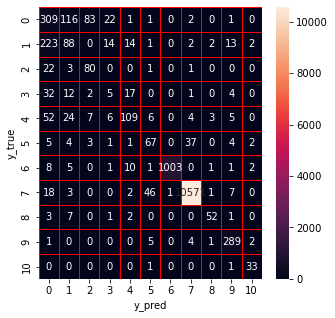

In [ ]:
rf = RandomForestClassifier(random_state = 0)
t1 = time.time()
rf.fit(X_train,y_train)
t2 = time.time() 
rf_score=rf.score(X_test,y_test)
t3 = time.time()
y_predict=rf.predict(X_test)
t4 = time.time()
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('RF (Original)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'RF_original.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': rf_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Train_time': t2-t1,
    'Predict_time_per_record': (t4/t3)/len_test,
    'HPO_time': np.NaN
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('RF (Original)')

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
available_criterion = ['gini','entropy']
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion', available_criterion)
}

t1 = time.time()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

t2 = time.time()

print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [03:25<00:00, 10.27s/trial, best loss: -0.942584086531338] 
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 12.0, 'max_features': 13.0, 'min_samples_leaf': 6.0, 'min_samples_split': 8.0, 'n_estimators': 62.0}


Accuracy of RF: 0.9413246406875092
Precision of RF: 0.944240452028322
Recall of RF: 0.9413246406875092
F1-score of RF: 0.9386178860964776
              precision    recall  f1-score   support

           0       0.52      0.75      0.61       535
           1       0.54      0.25      0.34       359
           2       0.51      0.98      0.68       107
           3       0.31      0.05      0.09        73
           4       0.76      0.46      0.57       216
           5       0.49      0.65      0.56       124
           6       1.00      0.97      0.98      1032
           7       1.00      0.99      0.99     10649
           8       0.76      0.85      0.80        66
           9       0.84      0.94      0.88       302
          10       0.68      0.91      0.78        35

    accuracy                           0.94     13498
   macro avg       0.67      0.71      0.66     13498
weighted avg       0.94      0.94      0.94     13498



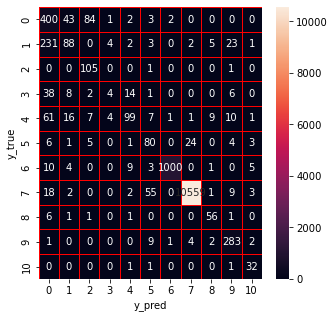

In [ ]:
params = {
    'n_estimators': int(best['n_estimators']), 
    'max_depth': int(best['max_depth']),
    'max_features': int(best['max_features']),
    "min_samples_split":int(best['min_samples_split']),
    "min_samples_leaf":int(best['min_samples_leaf']),
    "criterion":available_criterion[int(best['criterion'])]
}
rf_hpo = RandomForestClassifier(**params)
t3 = time.time()
rf_hpo.fit(X_train,y_train)
t4 = time.time()
rf_score=rf_hpo.score(X_test,y_test)
t5 = time.time()
y_predict=rf_hpo.predict(X_test)
t6 = time.time()
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('RF (BO-TPE)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'RF_BO-TPE.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': rf_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('RF (BO-TPE)')

In [ ]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Hyperparameter optimization (HPO) of random forest using Particle Swarm Optimization (PSO)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#Random Forest
import optunity
import optunity.metrics

data=X
labels=y.tolist()
Y_train = y_train
Y_test = y_test
# Define the hyperparameter configuration space
search = {
    'n_estimators': [10, 100],
    'max_features': [1, 20],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
    "criterion":[0,1]
         }
available_criterion = ['gini', 'entropy']
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_estimators=None, max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,criterion=None):
    # fit the model
    if criterion<0.5:
        cri=available_criterion[0]
    else:
        cri=available_criterion[1]
    model = RandomForestClassifier(n_estimators=int(n_estimators),
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri,
                                  )
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    # scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
    #                                 scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return optunity.metrics.accuracy(Y_test, predictions)

t1 = time.time()

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )

t2 = time.time()

print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

{'n_estimators': 51.30859375, 'max_features': 3.634765625, 'max_depth': 16.865234375, 'min_samples_split': 7.220703125, 'min_samples_leaf': 8.87109375, 'criterion': 0.896484375}
Accuracy:0.9420407961673335


Accuracy of RF: 0.9422136612831531
Precision of RF: 0.9465924092938208
Recall of RF: 0.9422136612831531
F1-score of RF: 0.9386356398629404
              precision    recall  f1-score   support

           0       0.52      0.79      0.63       535
           1       0.66      0.23      0.34       359
           2       0.50      0.91      0.65       107
           3       0.40      0.03      0.05        73
           4       0.69      0.45      0.55       216
           5       0.53      0.64      0.58       124
           6       1.00      0.97      0.98      1032
           7       1.00      0.99      0.99     10649
           8       0.77      0.85      0.81        66
           9       0.83      0.94      0.88       302
          10       0.52      0.89      0.65        35

    accuracy                           0.94     13498
   macro avg       0.67      0.70      0.65     13498
weighted avg       0.95      0.94      0.94     13498



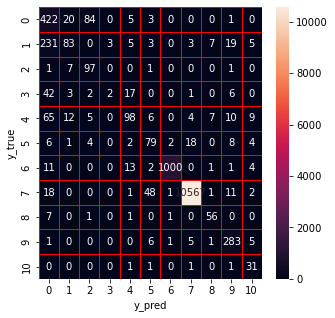

In [ ]:
params = {
    'n_estimators': int(optimal_configuration['n_estimators']), 
    'min_samples_leaf': int(optimal_configuration['min_samples_leaf']), 
    'max_depth': int(optimal_configuration['max_depth']), 
    'min_samples_split': int(optimal_configuration['min_samples_split']), 
    'max_features': int(optimal_configuration['max_features']), 
    'criterion': available_criterion[int(optimal_configuration['criterion']+0.5)]
}
rf_hpo = RandomForestClassifier(**params)
t3 = time.time()
rf_hpo.fit(X_train,y_train)
t4 = time.time()
rf_score=rf_hpo.score(X_test,y_test)
t5 = time.time()
y_predict=rf_hpo.predict(X_test)
t6 = time.time()
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('RF (PSO)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'RF_PSO.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': rf_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('RF (PSO)')

#### Hyperparameter optimization (HPO) of random forest using Genetic Algorithm (GA)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#Random Forest
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
    'n_estimators': range(20,200),
    "max_features":range(1,20),
    'max_depth': range(10,100),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    "criterion":['gini','entropy']
             }
# Set the hyperparameters of GA                 
ga = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
t1 = time.time()
ga.fit(X_combined, y_combined)
t2 = time.time()

1 operators have been imported by TPOT.
                                                                            
Generation 1 - Current Pareto front scores:
                                                                            
-1	0.9304163357178427	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=15, RandomForestClassifier__max_features=7, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=81)
                                                                            
Generation 2 - Current Pareto front scores:
                                                                            
-1	0.9304163357178427	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=15, RandomForestClassifier__max_features=7, RandomForestClassifier

Accuracy of RF: 0.9396947695954956
Precision of RF: 0.9412391157715357
Recall of RF: 0.9396947695954956
F1-score of RF: 0.9378138291293365
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       535
           1       0.47      0.26      0.33       359
           2       0.50      0.91      0.64       107
           3       0.25      0.07      0.11        73
           4       0.72      0.50      0.59       216
           5       0.50      0.62      0.56       124
           6       1.00      0.97      0.98      1032
           7       1.00      0.99      0.99     10649
           8       0.85      0.83      0.84        66
           9       0.84      0.94      0.89       302
          10       0.73      0.91      0.81        35

    accuracy                           0.94     13498
   macro avg       0.67      0.70      0.67     13498
weighted avg       0.94      0.94      0.94     13498



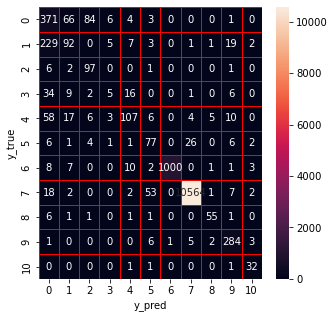

In [ ]:
rf_hpo = RandomForestClassifier(**get_ga_optimized_parameters(ga, 'RandomForestClassifier'))
t3 = time.time()
rf_hpo.fit(X_train,y_train)
t4 = time.time()
rf_score=rf_hpo.score(X_test,y_test)
t5 = time.time()
y_predict=rf_hpo.predict(X_test)
t6 = time.time()
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('RF (GA)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'RF_GA.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': rf_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('RF (GA)')

#### Apply DT

Accuracy of DT: 0.9252481849162839
Precision of DT: 0.9257031294401957
Recall of DT: 0.9252481849162839
F1-score of DT: 0.924588163155752
              precision    recall  f1-score   support

           0       0.41      0.54      0.47       536
           1       0.28      0.21      0.24       359
           2       0.45      0.59      0.51       107
           3       0.04      0.03      0.03        73
           4       0.63      0.45      0.52       215
           5       0.45      0.46      0.46       127
           6       0.99      0.98      0.98      1034
           7       0.99      0.99      0.99     10646
           8       0.76      0.66      0.71        64
           9       0.85      0.86      0.85       302
          10       0.83      0.86      0.85        35

    accuracy                           0.93     13498
   macro avg       0.61      0.60      0.60     13498
weighted avg       0.93      0.93      0.92     13498



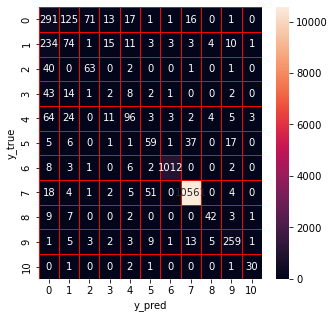

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
t1 = time.time()
dt.fit(X_train,y_train)
t2 = time.time() 
dt_score=dt.score(X_test,y_test)
t3 = time.time()
y_predict=dt.predict(X_test)
t4 = time.time()
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('DT (Original)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'DT_original.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': dt_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Train_time': t2-t1,
    'Predict_time_per_record': (t4-t3)/len_test,
    'HPO_time': np.NaN
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('DT (Original)')

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
available_criterion = ['gini','entropy']
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',available_criterion)
}

t1 = time.time()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

t2 = time.time()

print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|██████████| 50/50 [00:10<00:00,  4.70trial/s, best loss: -0.937842643354571] 
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 10.0, 'max_features': 14.0, 'min_samples_leaf': 3.0, 'min_samples_split': 3.0}


Accuracy of DT: 0.9375463031560232
Precision of DT: 0.943092848462321
Recall of DT: 0.9375463031560232
F1-score of DT: 0.935396470669343
              precision    recall  f1-score   support

           0       0.52      0.76      0.62       536
           1       0.59      0.24      0.34       359
           2       0.53      0.94      0.68       107
           3       0.13      0.05      0.08        73
           4       0.82      0.41      0.55       215
           5       0.45      0.73      0.56       127
           6       1.00      0.97      0.98      1034
           7       1.00      0.99      0.99     10646
           8       0.52      0.70      0.60        64
           9       0.80      0.87      0.83       302
          10       0.72      0.89      0.79        35

    accuracy                           0.94     13498
   macro avg       0.64      0.69      0.64     13498
weighted avg       0.94      0.94      0.94     13498



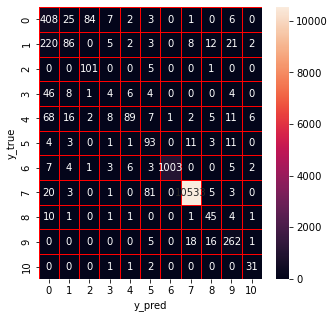

In [ ]:
params = {
    'max_depth': int(best['max_depth']),
    'max_features': int(best['max_features']),
    "min_samples_split":int(best['min_samples_split']),
    "min_samples_leaf":int(best['min_samples_leaf']),
    "criterion":available_criterion[int(best['criterion'])]
}
dt_hpo = DecisionTreeClassifier(**params)
t3 = time.time()
dt_hpo.fit(X_train,y_train)
t4 = time.time()
dt_score=dt_hpo.score(X_test,y_test)
t5 = time.time()
y_predict=dt_hpo.predict(X_test)
t6 = time.time()
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('DT (BO-TPE)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'DT_BO-TPE.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': dt_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('DT (BO-TPE)')

In [ ]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Hyperparameter optimization (HPO) of decision tree using Particle Swarm Optimization (PSO)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#Random Forest
import optunity
import optunity.metrics

data=X_train
labels=y_train.tolist()
Y_train = y_train
Y_test = y_test
# Define the hyperparameter configuration space
search = {
    'max_features': [1, 20],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
    "criterion":[0,1]
}
available_criterion = ['gini', 'entropy']
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,criterion=None):
    # fit the model
    if criterion<0.5:
        cri=available_criterion[0]
    else:
        cri=available_criterion[1]
    model = DecisionTreeClassifier(max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri,
                                  )
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    # scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    # scoring="accuracy"))
    # return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return optunity.metrics.accuracy(Y_test, predictions)

t1 = time.time()

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )

t2 = time.time()

print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

In [ ]:
params = {
    'min_samples_leaf': int(optimal_configuration['min_samples_leaf']), 
    'max_depth': int(optimal_configuration['max_depth']), 
    'min_samples_split': int(optimal_configuration['min_samples_split']), 
    'max_features': int(optimal_configuration['max_features']), 
    'criterion': available_criterion[int(optimal_configuration['criterion']+0.5)]
}
dt_hpo = DecisionTreeClassifier(**params)
t3 = time.time()
dt_hpo.fit(X_train,y_train)
t4 = time.time()
dt_score=dt_hpo.score(X_test,y_test)
t5 = time.time()
y_predict=dt_hpo.predict(X_test)
t6 = time.time()
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('DT (PSO)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'DT_PSO.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': dt_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('DT (PSO)')

#### Hyperparameter optimization (HPO) of decision tree using Genetic Algorithm (GA)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#Random Forest
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
    "max_features":range(1,20),
    'max_depth': range(10,100),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    "criterion":['gini','entropy']
}
# Set the hyperparameters of GA                 
ga = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.tree.DecisionTreeClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
t1 = time.time()
ga.fit(X_combined, y_combined)
t2 = time.time()

In [ ]:
dt_hpo = DecisionTreeClassifier(**get_ga_optimized_parameters(ga, 'DecisionTreeClassifier'))
t3 = time.time()
dt_hpo.fit(X_train,y_train)
t4 = time.time()
dt_score=dt_hpo.score(X_test,y_test)
t5 = time.time()
y_predict=dt_hpo.predict(X_test)
t6 = time.time()
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('DT (GA)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'DT_GA.pdf'))
plt.show()

UnboundLocalError: local variable 'pipeline' referenced before assignment

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': dt_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('DT (GA)')

#### Apply ET

Accuracy of ET: 0.9310268187879686
Precision of ET: 0.9320035200974949
Recall of ET: 0.9310268187879686
F1-score of ET: 0.9301638197966925
              precision    recall  f1-score   support

           0       0.43      0.59      0.50       536
           1       0.31      0.22      0.26       359
           2       0.45      0.59      0.51       107
           3       0.07      0.04      0.05        73
           4       0.72      0.46      0.56       215
           5       0.55      0.59      0.57       127
           6       0.99      0.98      0.98      1034
           7       1.00      0.99      0.99     10646
           8       0.74      0.66      0.69        64
           9       0.85      0.95      0.90       302
          10       0.75      0.86      0.80        35

    accuracy                           0.93     13498
   macro avg       0.62      0.63      0.62     13498
weighted avg       0.93      0.93      0.93     13498



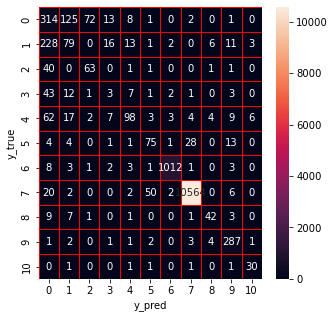

In [ ]:
et = ExtraTreesClassifier(random_state = 0)
t1 = time.time()
et.fit(X_train,y_train)
t2 = time.time() 
et_score=et.score(X_test,y_test)
t3 = time.time()
y_predict=et.predict(X_test)
t4 = time.time()
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('ET (Original)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'ET_original.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': et_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Train_time': t2-t1,
    'Predict_time_per_record': (t4-t3)/len_test,
    'HPO_time': np.NaN
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('ET (Original)')

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
available_criterion = ['gini','entropy']
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',available_criterion)
}

t1 = time.time()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

t2 = time.time()

print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [01:03<00:00,  3.15s/trial, best loss: -0.9393243443473107]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 16.0, 'max_features': 14.0, 'min_samples_leaf': 3.0, 'min_samples_split': 10.0, 'n_estimators': 75.0}


Accuracy of ET: 0.9388057489998518
Precision of ET: 0.9424155857262476
Recall of ET: 0.9388057489998518
F1-score of ET: 0.9364766360699387
              precision    recall  f1-score   support

           0       0.50      0.73      0.60       536
           1       0.54      0.24      0.33       359
           2       0.53      0.90      0.66       107
           3       0.12      0.05      0.07        73
           4       0.83      0.43      0.56       215
           5       0.52      0.64      0.57       127
           6       0.99      0.97      0.98      1034
           7       1.00      0.99      0.99     10646
           8       0.62      0.75      0.68        64
           9       0.80      0.92      0.86       302
          10       0.62      0.91      0.74        35

    accuracy                           0.94     13498
   macro avg       0.64      0.69      0.64     13498
weighted avg       0.94      0.94      0.94     13498



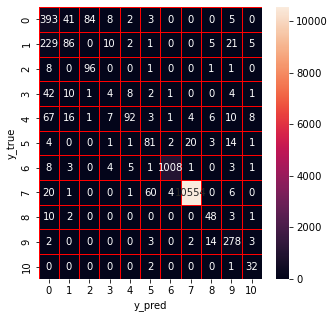

In [ ]:
params = {
    'n_estimators': int(best['n_estimators']), 
    'max_depth': int(best['max_depth']),
    'max_features': int(best['max_features']),
    "min_samples_split":int(best['min_samples_split']),
    "min_samples_leaf":int(best['min_samples_leaf']),
    "criterion":available_criterion[int(best['criterion'])]
}
et_hpo = ExtraTreesClassifier(**params)
t3 = time.time()
et_hpo.fit(X_train,y_train) 
t4 = time.time()
et_score=et_hpo.score(X_test,y_test)
t5 = time.time()
y_predict=et_hpo.predict(X_test)
t6 = time.time()
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('ET (BO-TPE)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'ET_BO-TPE.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': et_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('ET (BO-TPE)')

In [ ]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

#### Hyperparameter optimization (HPO) of extra trees using Particle Swarm Optimization (PSO)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#Random Forest
import optunity
import optunity.metrics

data=X_train
labels=y_train.tolist()
Y_train = y_train
Y_test = y_test
# Define the hyperparameter configuration space
search = {
    'n_estimators': [10, 200],
    'max_features': [1, 20],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
    "criterion":[0,1]
}
available_criterion = ['gini', 'entropy']
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_estimators=None,max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,criterion=None):
    # fit the model
    if criterion<0.5:
        cri=available_criterion[0]
    else:
        cri=available_criterion[1]
    model = ExtraTreesClassifier(n_estimators=int(n_estimators),
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri,
                                  )
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    # scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    # scoring="accuracy"))
    # return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return optunity.metrics.accuracy(Y_test, predictions)

t1 = time.time()

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )

t2 = time.time()

print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

In [ ]:
params = {
    'n_estimators': int(optimal_configuration['n_estimators']), 
    'min_samples_leaf': int(optimal_configuration['min_samples_leaf']), 
    'max_depth': int(optimal_configuration['max_depth']), 
    'min_samples_split': int(optimal_configuration['min_samples_split']), 
    'max_features': int(optimal_configuration['max_features']), 
    'criterion': available_criterion[int(optimal_configuration['criterion']+0.5)]
}
et_hpo = ExtraTreesClassifier(**params)
t3 = time.time()
et_hpo.fit(X_train,y_train)
t4 = time.time() 
et_score=et_hpo.score(X_test,y_test)
t5 = time.time()
y_predict=et_hpo.predict(X_test)
t6 = time.time()
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('ET (PSO)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'ET_PSO.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': et_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('ET (PSO)')

#### Hyperparameter optimization (HPO) of extra trees using Genetic Algorithm (GA)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#Random Forest
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
    'n_estimators': range(20,200),
    "max_features":range(1,20),
    'max_depth': range(10,100),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    "criterion":['gini','entropy']
             }
# Set the hyperparameters of GA                 
ga = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.ExtraTreesClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
t1 = time.time()
ga.fit(X_combined, y_combined)
t2 = time.time()

In [ ]:
et_hpo = ExtraTreesClassifier(**get_ga_optimized_parameters(ga, 'ExtraTreesClassifier'))
t3 = time.time()
et_hpo.fit(X_train,y_train)
t4 = time.time() 
et_score=et_hpo.score(X_test,y_test)
t5 = time.time()
y_predict=et_hpo.predict(X_test)
t6 = time.time()
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('ET (GA)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'ET_GA.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': et_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('ET (GA)')

### Apply stacking

In [ ]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
    'RandomForest': rf_train.ravel(),
    'ExtraTrees': et_train.ravel(),
    'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,7,7,7
1,7,7,7,7
2,7,7,7,7
3,7,7,7,7
4,7,7,7,7


In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [ ]:
dt_train.shape

(57508, 1)

In [ ]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

[20:35:02] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of Stacking: 0.937916728404208
Precision of Stacking: 0.937970317946802
Recall of Stacking: 0.937916728404208
F1-score of Stacking: 0.9356090859731018
              precision    recall  f1-score   support

           0       0.49      0.68      0.56       536
           1       0.41      0.22      0.29       359
           2       0.52      0.90      0.66       107
           3       0.10      0.05      0.07        73
           4       0.73      0.47      0.57       215
           5       0.52      0.54      0.53       127
           6       0.99      0.98      0.99      1034
           7       1.00      0.99      0.99     10646
           8       0.76      0.69      0.72        64
         

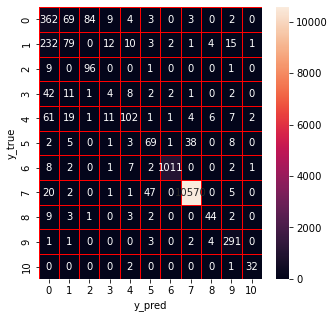

In [ ]:
t1 = time.time()
stk = xgb.XGBClassifier().fit(x_train, y_train)
t2 = time.time()
y_predict=stk.predict(x_test)
t3 = time.time()
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('Stacking (Original)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'Stacking_original.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': stk_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Train_time': t2-t1,
    'Predict_time_per_record': (t3-t2)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('Stacking (Original)')

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

t1 = time.time()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

t2 = time.time()

print("XGBoost: Hyperopt estimated optimum {}".format(best))

[20:35:13] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:21] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:22] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:23] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation

[20:36:45] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.938064898503482
Precision of XGBoost: 0.9381270173648902
Recall of XGBoost: 0.938064898503482
F1-score of XGBoost: 0.9356932609211833
              precision    recall  f1-score   support

           0       0.49      0.68      0.57       536
           1       0.42      0.22      0.29       359
           2       0.52      0.90      0.66       107
           3       0.11      0.05      0.07        73
           4       0.73      0.47      0.57       215
           5       0.52      0.54      0.53       127
           6       0.99      0.98      0.99      1034
           7       1.00      0.99      0.99     10646
           8       0.76      0.69      0.72        64
           9

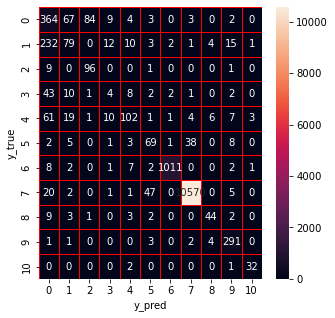

In [ ]:
params = {
    'n_estimators': int(best['n_estimators']), 
    'max_depth': int(best['max_depth']),
    'learning_rate':  abs(float(best['learning_rate'])),
}
xg = xgb.XGBClassifier(**params)
t3 = time.time()
xg.fit(x_train,y_train)
t4 = time.time()
xg_score=xg.score(x_test,y_test)
t5 = time.time()
y_predict=xg.predict(x_test)
t6 = time.time()
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('Stacking (BO-TPE)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'Stacking_BO-TPE.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': xg_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('Stacking (BO-TPE)')

#### Hyperparameter optimization (HPO) of stacking ensemble model (XGBoost) using Particle Swarm Optimization (PSO)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#XGBoost
import optunity
import optunity.metrics

data= X_combined
labels= y_combined.tolist()
Y_train = y_train
Y_test = y_test
# Define the hyperparameter configuration space
search = {
    'n_estimators': [10, 100],
    'max_depth': [5,50],
    'learning_rate': [0.01, 0.9]
}
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_estimators=None, max_depth=None,learning_rate=None):
    # fit the model
    params = {
        'n_estimators': int(n_estimators), 
        'max_depth': int(max_depth),
        'learning_rate':  abs(float(learning_rate)),
    }
    model = xgb.XGBClassifier( **params)
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    # scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
    #                                 scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return optunity.metrics.accuracy(Y_test, predictions)

t1 = time.time()

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )

t2 = time.time()

print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

In [ ]:
params = {
    'n_estimators': int(optimal_configuration['n_estimators']), 
    'max_depth': int(optimal_configuration['max_depth']), 
    'learning_rate': abs(float(optimal_configuration['learning_rate']))
}
xg = xgb.XGBClassifier(**params)
t3 = time.time()
xg.fit(x_train,y_train)
t4 = time.time()
xg_score=xg.score(x_test,y_test)
t5 = time.time()
y_predict=xg.predict(x_test)
t6 = time.time()
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('Stacking (PSO)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'Stacking_PSO.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': xg_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('Stacking (PSO)')

#### Hyperparameter optimization (HPO) of stacking ensemble model (XGBoost) using Genetic Algorithm (GA)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#XGBoost
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
    'n_estimators': range(10,100),
    'max_depth': range(4,100),
    'learning_rate': [i/100 for i in range(1, 90)]
}
# Set the hyperparameters of GA                 
ga = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'xgboost.XGBClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
t1 = time.time()
ga.fit(X_combined, y_combined)
t2 = time.time()

In [ ]:
xg = xgb.XGBClassifier(**get_ga_optimized_parameters(ga, 'XGBClassifier'))
t3 = time.time()
xg.fit(x_train,y_train)
t4 = time.time()
xg_score=xg.score(x_test,y_test)
t5 = time.time()
y_predict=xg.predict(x_test)
t6 = time.time()
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
report_str = classification_report(y_true,y_predict,target_names=label_names); log_file.write('******{}******\n'.format('Stacking (GA)')+report_str+'\n'); print(report_str)
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(18,14))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig(os.path.join(img_dir, 'Stacking_GA.pdf'))
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': xg_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'HPO_time': t2-t1,
    'Train_time': t4-t3,
    'Predict_time_per_record': (t6-t5)/len_test
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('Stacking (GA)')

In [ ]:
# Rename the index
output_df.index = output_index
# Save the result to file
output_df.to_excel(os.path.join(output_dir, 'result-{}.xlsx'.format(datetime.datetime.now().strftime('%y%m%d-%H%M%S'))))
# Close the logging file
log_file.close()

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [ ]:
# df=pd.read_csv('./data/UNSW-NB15_sample_km.csv')

In [ ]:
# df['attack_cat'].value_counts()

7     53253
6      5190
0      2677
1      1795
9      1511
4      1008
5       588
2       534
3       399
8       360
10      174
Name: attack_cat, dtype: int64

In [ ]:
# df1 = df[df['attack_cat'] != 9]
# df1['attack_cat'][df1['attack_cat'] != 7] = 1
# df1.to_csv('./data/UNSW-NB15_sample_km_without_shellcode.csv',index=0)

In [ ]:
# df2 = df[df['attack_cat'] == 9]
# df2['attack_cat'][df2['attack_cat'] == 9] = 1
# df2.to_csv('./data/UNSW-NB15_sample_km_shellcode.csv',index=0)

### Read the generated datasets for unknown attack detection

In [ ]:
# df1 = pd.read_csv('./data/UNSW-NB15_sample_km_without_shellcode.csv')
# df2 = pd.read_csv('./data/UNSW-NB15_sample_km_shellcode.csv')

In [ ]:
# features = df1.drop(['attack_cat'],axis=1).dtypes[df1.dtypes != 'object'].index
# df1[features] = df1[features].apply(
#     lambda x: (x - x.mean()) / (x.std()))
# df2[features] = df2[features].apply(
#     lambda x: (x - x.mean()) / (x.std()))
# df1 = df1.fillna(0)
# df2 = df2.fillna(0)

In [ ]:
# df1['attack_cat'].value_counts()

7    53253
1    12725
Name: attack_cat, dtype: int64

In [ ]:
# df2['attack_cat'].value_counts()

1    1511
Name: attack_cat, dtype: int64

In [ ]:
# df2p=df1[df1['attack_cat']==7]
# df2pp=df2p.sample(n=None, frac=1511/53253, replace=False, weights=None, random_state=None, axis=0)
# df2=pd.concat([df2, df2pp])

In [ ]:
# df2['attack_cat'].value_counts()

1    1511
7    1511
Name: attack_cat, dtype: int64

In [ ]:
# df = df1.append(df2)

In [ ]:
# X = df.drop(['attack_cat'],axis=1).values
# y = df.iloc[:, -1].values.reshape(-1,1)
# y=np.ravel(y)
# pd.Series(y).value_counts()

7    54764
1    14236
dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [ ]:
# from sklearn.feature_selection import mutual_info_classif
# importances = mutual_info_classif(X, y)

In [ ]:
# # calculate the sum of importance scores
# f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
# Sum = 0
# fs = []
# for i in range(0, len(f_list)):
#     Sum = Sum + f_list[i][0]
#     fs.append(f_list[i][1])

In [ ]:
# # select the important features from top to bottom until the accumulated importance reaches 90%
# f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
# Sum2 = 0
# fs = []
# for i in range(0, len(f_list2)):
#     Sum2 = Sum2 + f_list2[i][0]
#     fs.append(f_list2[i][1])
#     if Sum2>=0.9:
#         break        

In [ ]:
# X_fs = df[fs].values

In [ ]:
# X_fs.shape

(69000, 30)

In [ ]:
# X_fs

array([[-0.5157852 , -0.11993092, -0.47661465, ..., -1.12489896,
         1.06853583, -0.14827844],
       [-0.5157852 , -0.12107443, -0.47661465, ..., -1.12489896,
         1.06853583, -0.27440478],
       [-0.5157852 , -0.12164619, -0.47661465, ..., -1.12489896,
         1.06853583, -0.27440478],
       ...,
       [-0.17877201, -0.13079427, -0.47661465, ..., -1.12489896,
        -0.82616322,  1.49136388],
       [-0.5157852 , -0.10320709, -0.47661465, ...,  0.88895526,
        -0.82616322, -0.65278377],
       [-0.5157852 ,  1.18853067, -0.47661465, ...,  0.88895526,
        -0.82616322, -0.65278377]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [ ]:
# from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
# fcbf = FCBFK(k = 20)
# #fcbf.fit(X_fs, y)

In [ ]:
# X_fss = fcbf.fit_transform(X_fs,y)

In [ ]:
# X_fss.shape

(69000, 20)

In [ ]:
# X_fss

array([[-0.47661465, -0.5157852 , -0.06975683, ..., -0.34709766,
        -0.4143315 , -0.26561907],
       [-0.47661465, -0.5157852 , -0.06975683, ..., -0.33097366,
        -0.4143315 , -0.26561907],
       [-0.47661465, -0.5157852 , -0.06975683, ..., -0.3375741 ,
        -0.4143315 , -0.26561907],
       ...,
       [-0.47661465, -0.17877201, -0.64650816, ...,  0.71506847,
        -0.44488475, -0.26561907],
       [-0.47661465, -0.5157852 , -0.06975683, ..., -0.3336002 ,
        -0.29211847, -0.19592477],
       [-0.47661465, -0.5157852 , -0.06975683, ..., -0.23107668,
         0.31894669, -0.12623047]])

####  kernel principal component analysis (KPCA)

In [ ]:
# from sklearn.decomposition import KernelPCA
# kpca = KernelPCA(n_components = 10, kernel = 'rbf')
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

# # from sklearn.decomposition import PCA
# # kpca = PCA(n_components = 10)
# # kpca.fit(X_fss, y)
# # X_kpca = kpca.transform(X_fss)

MemoryError: Unable to allocate 35.5 GiB for an array with shape (69000, 69000) and data type float64

### Train-test split after feature selection

In [ ]:
# X_train = X_kpca[:len(df1)]
# y_train = y[:len(df1)]
# X_test = X_kpca[len(df1):]
# y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [ ]:
# pd.Series(y_train).value_counts()

0    18225
1     7320
dtype: int64

In [ ]:
# from imblearn.over_sampling import SMOTE
# smote=SMOTE(n_jobs=-1,sampling_strategy={1:18225})
# X_train, y_train = smote.fit_sample(X_train, y_train)

In [ ]:
# pd.Series(y_train).value_counts()

1    18225
0    18225
dtype: int64

In [ ]:
# pd.Series(y_test).value_counts()

1    1255
0    1255
dtype: int64

### Apply the cluster labeling (CL) k-means method

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.cluster import DBSCAN,MeanShift
# from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
# from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
# from sklearn.metrics import classification_report
# from sklearn import metrics

In [ ]:
# def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
#     km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
#     result = km_cluster.fit_predict(X_train)
#     result2 = km_cluster.predict(X_test)

#     count=0
#     a=np.zeros(n)
#     b=np.zeros(n)
#     for v in range(0,n):
#         for i in range(0,len(y_train)):
#             if result[i]==v:
#                 if y_train[i]==1:
#                     a[v]=a[v]+1
#                 else:
#                     b[v]=b[v]+1
#     list1=[]
#     list2=[]
#     for v in range(0,n):
#         if a[v]<=b[v]:
#             list1.append(v)
#         else: 
#             list2.append(v)
#     for v in range(0,len(y_test)):
#         if result2[v] in list1:
#             result2[v]=0
#         elif result2[v] in list2:
#             result2[v]=1
#         else:
#             print("-1")
#     print(classification_report(y_test, result2))
#     cm=confusion_matrix(y_test,result2)
#     acc=metrics.accuracy_score(y_test,result2)
#     print(str(acc))
#     print(cm)

In [ ]:
# CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       0.58      0.69      0.63      1255
           1       0.62      0.51      0.56      1255

    accuracy                           0.60      2510
   macro avg       0.60      0.60      0.60      2510
weighted avg       0.60      0.60      0.60      2510

0.5984063745019921
[[864 391]
 [617 638]]


### Hyperparameter optimization of CL-k-means
Tune "k"

In [ ]:
# #Hyperparameter optimization by BO-GP
# from skopt.space import Real, Integer
# from skopt.utils import use_named_args
# from sklearn import metrics

# space  = [Integer(2, 50, name='n_clusters')]
# @use_named_args(space)
# def objective(**params):
#     km_cluster = MiniBatchKMeans(batch_size=100, **params)
#     n=params['n_clusters']
    
#     result = km_cluster.fit_predict(X_train)
#     result2 = km_cluster.predict(X_test)

#     count=0
#     a=np.zeros(n)
#     b=np.zeros(n)
#     for v in range(0,n):
#         for i in range(0,len(y_train)):
#             if result[i]==v:
#                 if y_train[i]==1:
#                     a[v]=a[v]+1
#                 else:
#                     b[v]=b[v]+1
#     list1=[]
#     list2=[]
#     for v in range(0,n):
#         if a[v]<=b[v]:
#             list1.append(v)
#         else: 
#             list2.append(v)
#     for v in range(0,len(y_test)):
#         if result2[v] in list1:
#             result2[v]=0
#         elif result2[v] in list2:
#             result2[v]=1
#         else:
#             print("-1")
#     cm=metrics.accuracy_score(y_test,result2)
#     print(str(n)+" "+str(cm))
#     return (1-cm)
# from skopt import gp_minimize
# import time
# t1=time.time()
# res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
# t2=time.time()
# print(t2-t1)
# print("Best score=%.4f" % (1-res_gp.fun))
# print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

30 0.6972111553784861
43 0.7127490039840637
43 0.399203187250996
43 0.47051792828685257
32 0.653784860557769
20 0.34860557768924305
16 0.9195219123505977
5 0.4370517928286853
15 0.6729083665338645
25 0.7063745019920319
2 0.47808764940239046
50 0.4199203187250996


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


50 0.39282868525896414
17 0.42828685258964144


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


16 0.6992031872509961


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


16 0.3737051792828685


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


50 0.6250996015936255
9.127083539962769
Best score=0.9195
Best parameters: n_clusters=16


In [ ]:
# #Hyperparameter optimization by BO-TPE
# from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.cluster import MiniBatchKMeans
# from sklearn import metrics

# def objective(params):
#     params = {
#         'n_clusters': int(params['n_clusters']), 
#     }
#     km_cluster = MiniBatchKMeans(batch_size=100, **params)
#     n=params['n_clusters']
    
#     result = km_cluster.fit_predict(X_train)
#     result2 = km_cluster.predict(X_test)

#     count=0
#     a=np.zeros(n)
#     b=np.zeros(n)
#     for v in range(0,n):
#         for i in range(0,len(y_train)):
#             if result[i]==v:
#                 if y_train[i]==1:
#                     a[v]=a[v]+1
#                 else:
#                     b[v]=b[v]+1
#     list1=[]
#     list2=[]
#     for v in range(0,n):
#         if a[v]<=b[v]:
#             list1.append(v)
#         else: 
#             list2.append(v)
#     for v in range(0,len(y_test)):
#         if result2[v] in list1:
#             result2[v]=0
#         elif result2[v] in list2:
#             result2[v]=1
#         else:
#             print("-1")
#     score=metrics.accuracy_score(y_test,result2)
#     print(str(params['n_clusters'])+" "+str(score))
#     return {'loss':1-score, 'status': STATUS_OK }
# space = {
#     'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
# }

# best = fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=20)
# print("Random Forest: Hyperopt estimated optimum {}".format(best))

23 0.34422310756972113
15 0.6685258964143427
46 0.450199203187251
15 0.4896414342629482
29 0.6824701195219124
36 0.3888446215139442
22 0.35776892430278884
25 0.34860557768924305
42 0.41832669322709165
27 0.47051792828685257
26 0.39402390438247015
25 0.6824701195219124
33 0.3848605577689243
19 0.7191235059760956
6 0.5824701195219123
21 0.6697211155378486
24 0.451394422310757
37 0.4681274900398406
14 0.47250996015936253
21 0.8434262948207172
100%|███████████████████████████████████████████████| 20/20 [00:06<00:00,  2.87trial/s, best loss: 0.15657370517928282]
Random Forest: Hyperopt estimated optimum {'n_clusters': 21.0}


In [ ]:
# CL_kmeans(X_train, X_test, y_train, y_test, 16)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1255
           1       0.91      0.99      0.95      1255

    accuracy                           0.95      2510
   macro avg       0.95      0.95      0.94      2510
weighted avg       0.95      0.95      0.94      2510

0.9450199203187251
[[1127  128]
 [  10 1245]]


### Apply the CL-k-means model with biased classifiers

In [ ]:
# # needs to work on the entire dataset to generate sufficient training samples for biased classifiers
# def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
#     # CL-kmeans
#     km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
#     result = km_cluster.fit_predict(X_train)
#     result2 = km_cluster.predict(X_test)

#     count=0
#     a=np.zeros(n)
#     b=np.zeros(n)
#     for v in range(0,n):
#         for i in range(0,len(y_train)):
#             if result[i]==v:
#                 if y_train[i]==1:
#                     a[v]=a[v]+1
#                 else:
#                     b[v]=b[v]+1
#     list1=[]
#     list2=[]
#     for v in range(0,n):
#         if a[v]<=b[v]:
#             list1.append(v)
#         else: 
#             list2.append(v)
#     for v in range(0,len(y_test)):
#         if result2[v] in list1:
#             result2[v]=0
#         elif result2[v] in list2:
#             result2[v]=1
#         else:
#             print("-1")
#     print(classification_report(y_test, result2))
#     cm=confusion_matrix(y_test,result2)
#     acc=metrics.accuracy_score(y_test,result2)
#     print(str(acc))
#     print(cm)
    
#     #Biased classifier construction
#     count=0
#     print(len(y))
#     a=np.zeros(n)
#     b=np.zeros(n)
#     FNL=[]
#     FPL=[]
#     for v in range(0,n):
#         al=[]
#         bl=[]
#         for i in range(0,len(y)):   
#             if result[i]==v:        
#                 if y[i]==1:        #label 1
#                     a[v]=a[v]+1
#                     al.append(i)
#                 else:             #label 0
#                     b[v]=b[v]+1
#                     bl.append(i)
#         if a[v]<=b[v]:
#             FNL.extend(al)
#         else:
#             FPL.extend(bl)
#         #print(str(v)+"="+str(a[v]/(a[v]+b[v])))
        
#     dffp=df.iloc[FPL, :]
#     dffn=df.iloc[FNL, :]
#     dfva0=df[df['Label']==0]
#     dfva1=df[df['Label']==1]
    
#     dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
#     dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)
    
#     dffp_f=pd.concat([dffp, dffpp])
#     dffn_f=pd.concat([dffn, dffnp])
    
#     Xp = dffp_f.drop(['Label'],axis=1)  
#     yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
#     yp=np.ravel(yp)

#     Xn = dffn_f.drop(['Label'],axis=1)  
#     yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
#     yn=np.ravel(yn)
    
#     rfp = RandomForestClassifier(random_state = 0)
#     rfp.fit(Xp,yp)
#     rfn = RandomForestClassifier(random_state = 0)
#     rfn.fit(Xn,yn)

#     dffnn_f=pd.concat([dffn, dffnp])
    
#     Xnn = dffn_f.drop(['Label'],axis=1)  
#     ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
#     ynn=np.ravel(ynn)

#     rfnn = RandomForestClassifier(random_state = 0)
#     rfnn.fit(Xnn,ynn)

#     X2p = df2.drop(['Label'],axis=1) 
#     y2p = df2.iloc[:, -1].values.reshape(-1,1)
#     y2p=np.ravel(y2p)

#     result2 = km_cluster.predict(X2p)

#     count=0
#     a=np.zeros(n)
#     b=np.zeros(n)
#     for v in range(0,n):
#         for i in range(0,len(y)):
#             if result[i]==v:
#                 if y[i]==1:
#                     a[v]=a[v]+1
#                 else:
#                     b[v]=b[v]+1
#     list1=[]
#     list2=[]
#     l1=[]
#     l0=[]
#     for v in range(0,n):
#         if a[v]<=b[v]:
#             list1.append(v)
#         else: 
#             list2.append(v)
#     for v in range(0,len(y2p)):
#         if result2[v] in list1:
#             result2[v]=0
#             l0.append(v)
#         elif result2[v] in list2:
#             result2[v]=1
#             l1.append(v)
#         else:
#             print("-1")
#     print(classification_report(y2p, result2))
#     cm=confusion_matrix(y2p,result2)
#     print(cm)

More details are in the paper